In [54]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram
from src.plot_utils import *

In [102]:
sns.set(style='dark')

In [58]:
model.hparams.dafx_names

['mda Delay',
 'mda Overdrive',
 'mda Ambience',
 'mda RingMod',
 'mda Combo',
 'mda Dynamics']

In [106]:
DAFX_NAME = "mda Delay"
NUM_EXAMPLES_PER_SETTING = 200
NUM_SETTINGS = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/hdx3y4ly/checkpoints/epoch=169-step=35530.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [107]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [108]:
dafx = dafx_from_name(DAFX_NAME)

In [109]:
def get_interpolated_settings(dafx, setting_idx, num_samples=100):
    num_settings = len(dafx.param_names)

    assert(setting_idx <= num_settings)

    settings = []
    for i in np.linspace(0,1, num_samples):
        s = torch.ones(num_settings) * 0.5
        s[setting_idx] = i
        settings.append(s)

    return settings

In [110]:
settings_to_apply = get_interpolated_settings(dafx, 1, 10)

In [111]:
settings_to_apply

[tensor([0.5000, 0.0000, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.1111, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.2222, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.3333, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.4444, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.5556, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.6667, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.7778, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.8889, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 1.0000, 0.5000, 0.5000, 0.5000])]

In [112]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=37152, out_features=128, bias=True)
  (log_var): Linear(in_features=37152, 

In [113]:
latent_embeddings = dict()

In [114]:
dataset = get_audio_dataset(dafx_from_name('clean'),
                            num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING)

100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2074.02it/s]


Loaded 88 files for train = 66.89 hours.


In [115]:
for i in tqdm(range(dafx.get_num_params())):
    setting_name = dafx.idx_to_param_map[i]
    print(f"Interpolating setting: {setting_name}")
    embeddings = []
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    for setting in settings_to_apply:
        print(f"Applying setting: {setting}")
        for batch in dataset:
            x = batch

            # Apply setting to audio
            x = dafx.apply(x, setting)
            x = x.unsqueeze(0).unsqueeze(0)

            X = audio_to_spectrogram(signal=x,
                         n_fft=model.hparams.n_fft,
                         hop_length=model.hparams.hop_length,
                         window_size=model.hparams.window_size).to(DEVICE)

            _, _, _, z = model(X)

            embeddings.append(z.cpu().detach().numpy())

        latent_embeddings[setting_name] = np.array(embeddings)


  0%|          | 0/5 [00:00<?, ?it/s]

Interpolating setting: l_delay_ms
Applying setting: tensor([0.0000, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.1111, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.2222, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.3333, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.4444, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5556, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.6667, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.7778, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.8889, 0.5000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([1.0000, 0.5000, 0.5000, 0.5000, 0.5000])


 20%|██        | 1/5 [01:26<05:45, 86.42s/it]

Interpolating setting: r_delay
Applying setting: tensor([0.5000, 0.0000, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.1111, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.2222, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.3333, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.4444, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5556, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.6667, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.7778, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.8889, 0.5000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 1.0000, 0.5000, 0.5000, 0.5000])


 40%|████      | 2/5 [02:49<04:13, 84.38s/it]

Interpolating setting: feedback
Applying setting: tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.1111, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.2222, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.3333, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.4444, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5556, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.6667, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.7778, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.8889, 0.5000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 1.0000, 0.5000, 0.5000])


 60%|██████    | 3/5 [04:18<02:53, 86.52s/it]

Interpolating setting: fb_tone_lo_hi
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.0000, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.1111, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.2222, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.3333, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.4444, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5556, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.6667, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.7778, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.8889, 0.5000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 1.0000, 0.5000])


 80%|████████  | 4/5 [05:48<01:28, 88.09s/it]

Interpolating setting: fb_mix
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.0000])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.1111])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.2222])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.3333])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.4444])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5556])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.6667])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.7778])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.8889])
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 1.0000])


100%|██████████| 5/5 [07:27<00:00, 89.52s/it]


In [116]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [117]:
data.shape

(10000, 128)

In [118]:
reducer = umap.UMAP().fit(data)

In [119]:
EXPERIMENT_NAME = f"{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{NUM_SETTINGS}settings"

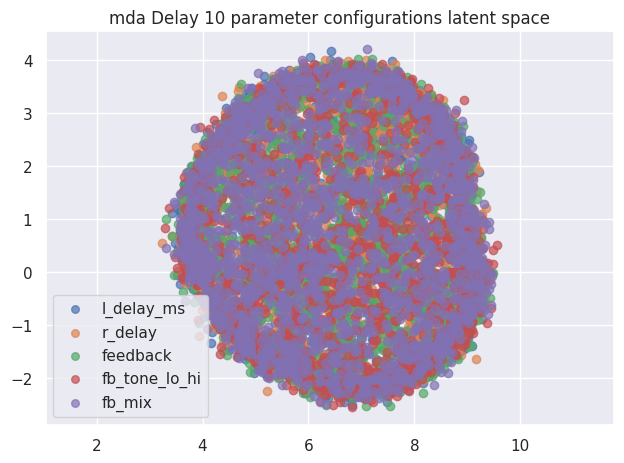

In [120]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.7)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")
plt.grid()

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_full.png"
# plt.savefig(figname)
plt.tight_layout()
plt.show()

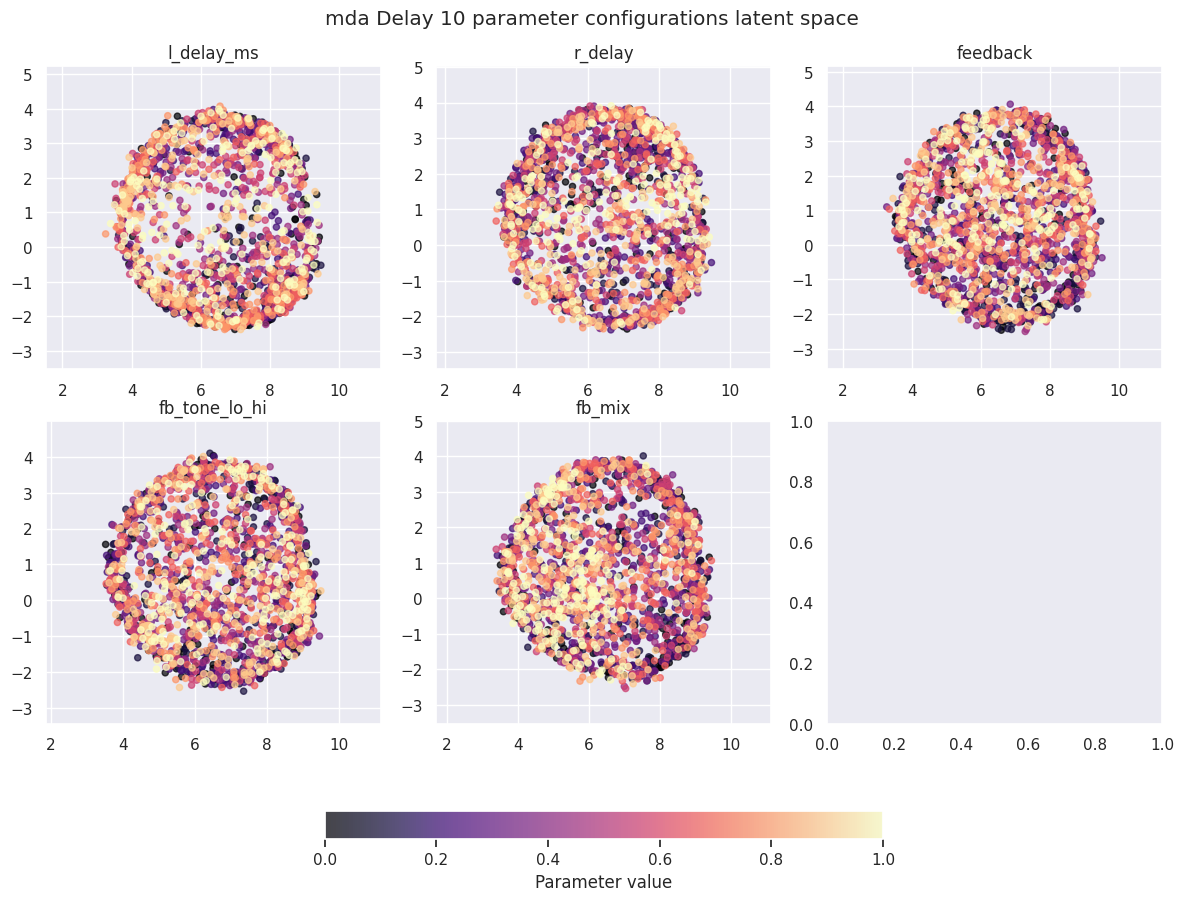

In [121]:
n = dafx.get_num_params() # Define the size of the plot
max_columns = 3  # set a maximum number of columns

num_rows, num_cols = get_subplot_dimensions(n, max_columns=max_columns)
# Create the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows + 2))

count = 0
for i in range(dafx.get_num_params()):
    row_idx, col_idx = divmod(count, num_cols)

    if num_rows == 1:
            current_ax = axs[col_idx]
    elif num_cols == 1:
        current_ax = axs[row_idx]
    else:
        current_ax = axs[row_idx, col_idx]

    param_name = dafx.idx_to_param_map[i]
    X = latent_embeddings[param_name]

    embeds = reducer.transform(X.squeeze())
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

    sc = current_ax.scatter(x=embeds[:,0], y=embeds[:,1], s=20, alpha=0.7, c=colours,
                            vmin=0, vmax=1, cmap='magma')

    current_ax.set_title(param_name)
    current_ax.grid()
    current_ax.set_aspect('equal', 'datalim')

    count += 1

    # If we have processed all the subplots, break out of the loop
    if count == n:
        break

fig.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

# If we have fewer subplots than required, remove the remaining subplots
while count < n:
    row_idx, col_idx = divmod(count, num_cols)
    axs[row_idx, col_idx].remove()
    # fig.delaxes()
    count += 1

# Adjust the spacing between subplots
fig.tight_layout()

# Add colorbar
cbar = fig.colorbar(sc, ax=axs.ravel().tolist(), aspect=20, shrink=.5, pad=.1, orientation='horizontal')
cbar.set_label('Parameter value')

plt.savefig(f"./figures/param_interpolation/{EXPERIMENT_NAME}_seperate.png")

In [122]:
# import matplotlib.gridspec as gridspec
#
# fig = plt.figure(figsize=(4.5*dafx.get_num_params(), 5))
# gs = gridspec.GridSpec(1, dafx.get_num_params() + 1, width_ratios=[1]*dafx.get_num_params() + [0.05])
#
# for i in range(dafx.get_num_params()):
#     param_name = dafx.idx_to_param_map[i]
#     X = latent_embeddings[param_name]
#
#     embeds = reducer.transform(X.squeeze())
#     settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
#     colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])
#
#     ax = fig.add_subplot(gs[0, i])
#     sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], alpha=0.7, c=colours, vmin=0, vmax=1, s=8, cmap='magma')
#
#     ax.set_title(param_name)
#     ax.set_aspect('equal', 'datalim')
#
# plt.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")
#
# cax = fig.add_subplot(gs[0, -1])
# plt.colorbar(sc, cax=cax)
#
# fig.subplots_adjust(right=0.9)
#
# figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_seperate.png"
# plt.savefig(figname)